In [1]:
from PIL import Image
import tqdm
import os
import time
import collections

import torch
import torchvision
assert torch.cuda.is_available()
from torchvision.transforms import ToTensor
from torch.nn import functional as F

import numpy as np
import matplotlib.pyplot as plt

AMOUNT = 13000
BATCH_SIZE = 22
VAL_SIZE = 0.2
IM_SIZE = (224, 224)
DEVICE = 'cuda:0'

----------------
## Создание Custom Dataset  и DataLoader
Объект класса ImageDataset подгружает файл с нужным изображением при вызове метода \__getitem__.

Работа происходит в цветовом пространстве HSV:
- hue - оттенок (image[0]),
- saturation - насыщенность (image[1]),
- value - значение яркости (image[2])

Яркость будет неизменным и опорным значением для модели, по которому будут рассчитываться два оставшихся параметра, влияющих на цвет.


In [2]:
def dataset_preparation(in_path, out_path, im_size):
    ''' перезаписывает файлы в другую папку + resize '''
    files_list = os.listdir(in_path)
    if not os.path.exists(out_path):
        os.makedirs(out_path)
    for file_n in tqdm.tqdm(files_list):
        with Image.open(in_path+file_n) as file:
            file.resize(im_size).save(out_path+file_n)

class ImageDataset(torch.utils.data.Dataset):
    ''' 
    Формат файлов: png или jpg
    amount - временное решение по ограничению кол-ва обучающих данных
    '''
    
    def __init__(self, path, transforms, amount = None, to_hsv = True):
        self.transforms = transforms
        self.to_hsv = to_hsv
        self.path = path
        
        is_image_filter = lambda value:('png' in value) or ('jpg' in value) or ('JPEG' in value)
        self.f_names = list(filter(is_image_filter, os.listdir(path)))[:amount]
        self.len = len(self.f_names)
        
    
    def __len__(self):
        return self.len
    
    def __getitem__(self, index):
        with Image.open(self.path + self.f_names[index]) as file:
            image = self.transforms(file.convert('HSV')) 
            return image[2].unsqueeze(0), image[:2]     # unsqueeze на случай реализации vgg16
                                                        # image shape - [hue, sat, val], return [newax, h, s]

transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
#     torchvision.transforms.Normalize(mean = 0.5, std=0.5)
])
# dataset_preparation(in_path = 'CelebA/',
#                     out_path = 'im_dataset2/',
#                     im_size = IM_SIZE)
dataset = ImageDataset(path = 'im_dataset2/', transforms = transforms, amount = AMOUNT)
# testdata = ImageDataset(path = 'tests/', transforms = transforms, amount = AMOUNT)

In [3]:
dataset_preparation(in_path = 'tests/',
                    out_path = 'tests/',
                    im_size = IM_SIZE)
testdata = ImageDataset(path = 'tests/', transforms = transforms, amount = AMOUNT)
test_loader = torch.utils.data.DataLoader(testdata, batch_size = 1)

100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 38.23it/s]


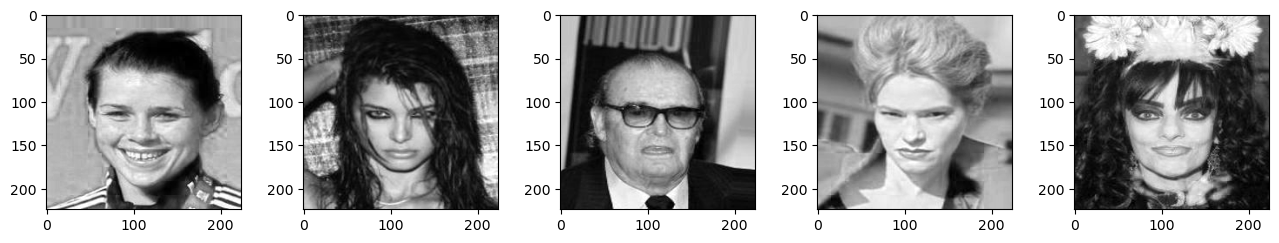

In [4]:
%matplotlib inline
_, ax = plt.subplots(1, 5, figsize = (13, 5))
plt.tight_layout()
for i in range(5):
    ax[i].imshow(dataset[i][0].permute(1, 2, 0), cmap = 'gray')

In [5]:
def val_split(dataset, val_size):
    ''' val_size задается в диапазоне 0..1 '''
    val_length = int(np.round(len(dataset) * val_size))
    val_idx = range(val_length)
    train_idx = range(val_length, len(dataset))
    
    train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
    val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)
    
    return train_sampler, val_sampler

train_sampler, val_sampler = val_split(dataset, val_size = VAL_SIZE)
train_loader = torch.utils.data.DataLoader(dataset, batch_size = BATCH_SIZE, sampler = train_sampler, drop_last = True)
val_loader = torch.utils.data.DataLoader(dataset, batch_size = BATCH_SIZE, sampler = val_sampler, drop_last = True)

---------------------------------------
## Архитектура модели
VGG в качестве feature extractor

In [6]:
class StylerNet(torch.nn.Module):
    ''' '''
    
    def __init__(self, optim):
        super(StylerNet, self).__init__()

        feature_extractor = torchvision.models.vgg16(pretrained = True)
        self.l1_encoder = torch.nn.Sequential(
            collections.OrderedDict({
                'conv1': feature_extractor.features[:5],
                'conv2': feature_extractor.features[5:10],
                'conv3': feature_extractor.features[10:17],
                'conv4': feature_extractor.features[17:30]
            })
        )
        for param in self.l1_encoder.parameters():
            param.requires_grad = False
        
        self.l2_decoder = torch.nn.Sequential(
            collections.OrderedDict({
                'convTranspose1': torch.nn.Sequential(
                    torch.nn.ConvTranspose2d(in_channels = 512, out_channels = 512, kernel_size = 3, padding = 1),
                    torch.nn.LeakyReLU(),
                    torch.nn.ConvTranspose2d(in_channels = 512, out_channels = 256, kernel_size = 3, stride = 2, padding = 1, output_padding = 1),
                    torch.nn.LeakyReLU(),
                    torch.nn.BatchNorm2d(256)
                ),
                'convTranspose2': torch.nn.Sequential(
                    torch.nn.ConvTranspose2d(in_channels = 512, out_channels = 256, kernel_size = 3, padding = 1),
                    torch.nn.LeakyReLU(),
                    torch.nn.ConvTranspose2d(in_channels = 256, out_channels = 128, kernel_size = 3, stride = 2, padding = 1, output_padding = 1),
                    torch.nn.LeakyReLU(),
                    torch.nn.BatchNorm2d(128),
                ),
                'convTranspose3': torch.nn.Sequential(            
                    torch.nn.ConvTranspose2d(in_channels = 256, out_channels = 128, kernel_size = 3, padding = 1),
                    torch.nn.LeakyReLU(),
                    torch.nn.ConvTranspose2d(in_channels = 128, out_channels = 64, kernel_size = 3, stride = 2, padding = 1, output_padding = 1),
                    torch.nn.LeakyReLU(),
                    torch.nn.BatchNorm2d(64),
                ),
                'convTranspose4': torch.nn.Sequential(
                    torch.nn.ConvTranspose2d(in_channels = 128, out_channels = 64, kernel_size = 3, padding = 1),
                    torch.nn.LeakyReLU(),
                    torch.nn.ConvTranspose2d(in_channels = 64, out_channels = 32, kernel_size = 3, stride = 2, padding = 1, output_padding = 1),
                    torch.nn.LeakyReLU(),
                    torch.nn.BatchNorm2d(32),
                ),
                'convOut': torch.nn.Sequential(
                    torch.nn.Conv2d(in_channels = 32, out_channels = 2, kernel_size = 3, padding = 1),
                    torch.nn.BatchNorm2d(2),
                    torch.nn.Sigmoid()
                )
            })    
        )
        self.loss_fn = torch.nn.BCELoss()
        self.optim = optim(self.parameters(), lr = .01)
        
    def forward(self, x):
        x = torch.cat([x, x, x], axis=1)
        
        x1 = self.l1_encoder.conv1(x)          # (, 64, 64, 64)
        x2 = self.l1_encoder.conv2(x1)         # (, 128, 32, 32)
        x3 = self.l1_encoder.conv3(x2)         # (, 256, 16, 16)
        
        x4 = self.l1_encoder.conv4(x3)         # (, 512, 8, 8)
        x = self.l2_decoder.convTranspose1(x4) # (, 1024, 4, 4)
        
        x = torch.cat((x, x3), dim = 1)        # ( , 512, 16, 16)
        x = self.l2_decoder.convTranspose2(x)  
        x = torch.cat((x, x2), dim = 1)        # ( , 256, 32, 32)
        x = self.l2_decoder.convTranspose3(x)
        x = torch.cat((x, x1), dim = 1)        # ( , 128, 64, 64)
        x = self.l2_decoder.convTranspose4(x)  # ( , 32, 128, 128)
        
        x = self.l2_decoder.convOut(x)
        return x
    
    def calc_loss(self, outputs, targets):
        return self.loss_fn(outputs, targets)
            
    def predict(self, inputs):
        topillow = torchvision.transforms.ToPILImage('HSV')
        image = topillow(torch.hstack([self(inputs.to(DEVICE)), inputs.to(DEVICE)])[0])
        return image
    def checkpoint(self, direction, epoch):
        torch.save(self.state_dict, direction + f'model_{epoch}')
    def load_checkpoint(self, direction, epoch):
        self.load_state_dict(torch.load(direction + f'model_{epoch}')())

--------------
## Обучение

In [7]:
def train_model3(model, train_loader, epochs=1, loss=np.array([]), device = DEVICE):
    model.to(device)
    model.train()
    
    # для val_loss
    calc_loss = torch.nn.MSELoss()
    topillow = torchvision.transforms.ToPILImage('HSV')
    image = next(iter(val_loader))     # image shape   [[s, h], v]
    
    point = np.ceil(len(train_loader) / 10)
    
    for epoch in range(epochs):
        model.to(device)
        start_time = time.time()
        print(f'Epoch {epoch}/{epochs}: <', end = '')
        
        for i, (inputs, targets) in enumerate(train_loader):
            model.optim.zero_grad()
            model_outs = model(inputs.to(device))
            model_loss = model.calc_loss(model_outs, targets.to(device))
            model_loss.backward()
            model.optim.step()
            
            
            if not i % point:
                print('=', end = '')
                
        print(f'> ------- model loss = {model_loss}, time = {np.round(time.time() - start_time)}s')
        
        loss = np.append(loss, model_loss.detach().to('cpu').numpy())
        
        
        if not epoch % 5:
            model.checkpoint('checkpoints/', epoch)
#             model.save_result('checkpoints/', epoch)
            
            # расчет validation loss    
            with torch.no_grad():                  
                val_loss = 0
                for i, (inputs, targets) in enumerate(val_loader):
                    outputs = model(inputs.to(device))
                    val_loss += calc_loss(outputs, targets.to(device))
                val_loss = val_loss / i
                print(f'\nValidation loss = {val_loss}')
                
                # визуальный вывод
                fake_im = model.predict(image[0])
                real_im = topillow(torch.hstack((image[1], image[0]))[0])    # im[0] - V; image[1] - H,S
                _, ax = plt.subplots(1, 3, figsize = (10, 2))
                plt.tight_layout()
                ax[0].set_title('fake image')
                ax[0].imshow(fake_im)
                ax[1].set_title('real image')
                ax[1].imshow(real_im)
                ax[2].set_title('losses')
                ax[2].plot(loss, label = 'model loss')
                ax[2].legend()
                plt.show()
                

    return loss

In [11]:
model = StylerNet(optim = torch.optim.Adam)
model_params_amount = (sum(p.numel() for p in model.parameters()))
print(f'Количество параметров модели: {model_params_amount}')

Количество параметров модели: 20191974


Epoch 0/70: <==========> ------- model loss = 0.5138906240463257, time = 146.0s

Validation loss = 0.06630359590053558


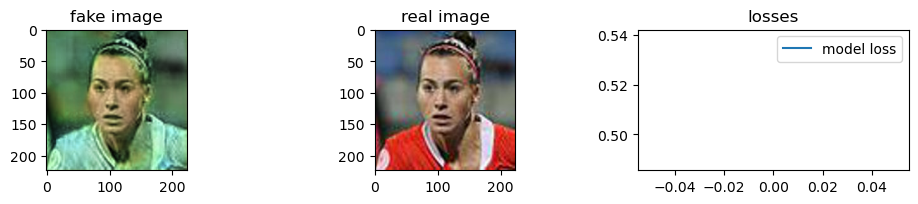

Epoch 1/70: <==========> ------- model loss = 0.5721385478973389, time = 145.0s
Epoch 2/70: <==========> ------- model loss = 0.43442782759666443, time = 152.0s
Epoch 3/70: <==========> ------- model loss = 0.4567239582538605, time = 151.0s
Epoch 4/70: <==========> ------- model loss = 0.4339616298675537, time = 144.0s
Epoch 5/70: <==========> ------- model loss = 0.5177693963050842, time = 137.0s

Validation loss = 0.06114302948117256


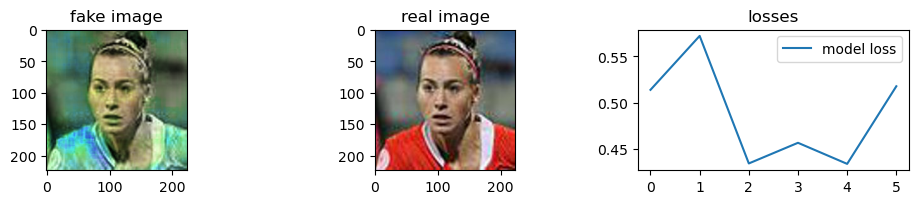

Epoch 6/70: <==========> ------- model loss = 0.4607636332511902, time = 141.0s
Epoch 7/70: <==========> ------- model loss = 0.5385069847106934, time = 147.0s
Epoch 8/70: <==========> ------- model loss = 0.4533642530441284, time = 137.0s
Epoch 9/70: <==========> ------- model loss = 0.4262455105781555, time = 136.0s
Epoch 10/70: <==========> ------- model loss = 0.4808836579322815, time = 138.0s

Validation loss = 0.06631840020418167


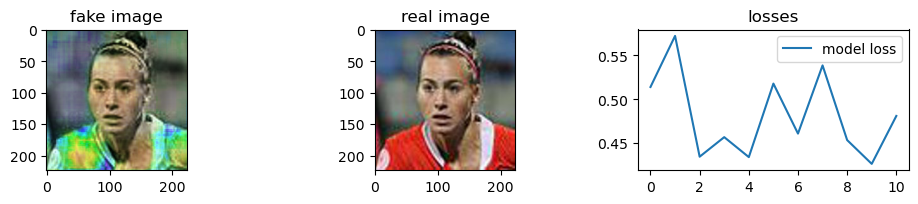

Epoch 11/70: <==========> ------- model loss = 0.4333361089229584, time = 139.0s
Epoch 12/70: <==========> ------- model loss = 0.5710902810096741, time = 139.0s
Epoch 13/70: <==========> ------- model loss = 0.42379558086395264, time = 139.0s
Epoch 14/70: <==========> ------- model loss = 0.4173339903354645, time = 141.0s
Epoch 15/70: <==========> ------- model loss = 0.4559814929962158, time = 138.0s

Validation loss = 0.07346560060977936


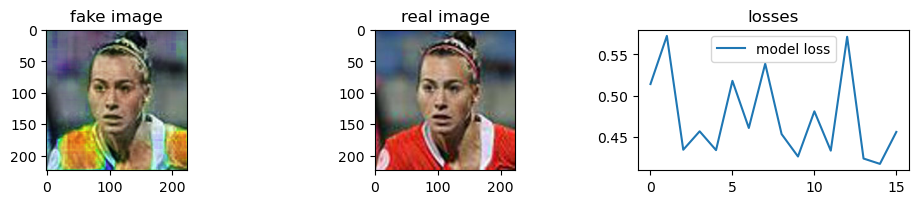

Epoch 16/70: <==========> ------- model loss = 0.413347989320755, time = 137.0s
Epoch 17/70: <==========> ------- model loss = 0.3941816985607147, time = 137.0s
Epoch 18/70: <==========> ------- model loss = 0.3688836395740509, time = 138.0s
Epoch 19/70: <==========> ------- model loss = 0.3266429007053375, time = 138.0s
Epoch 20/70: <==========> ------- model loss = 0.433345764875412, time = 141.0s

Validation loss = 0.07816237956285477


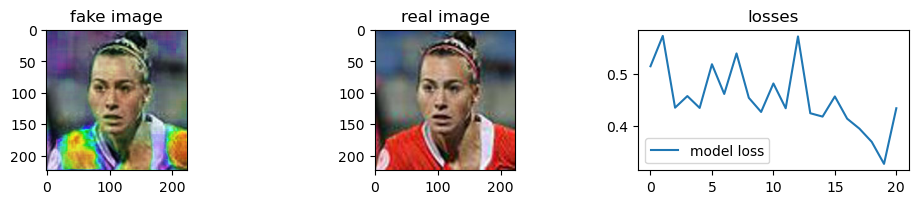

Epoch 21/70: <==========> ------- model loss = 0.3647240996360779, time = 141.0s
Epoch 22/70: <==========> ------- model loss = 0.42641061544418335, time = 140.0s
Epoch 23/70: <==========> ------- model loss = 0.4267425239086151, time = 141.0s
Epoch 24/70: <==========> ------- model loss = 0.38462862372398376, time = 138.0s
Epoch 25/70: <==========> ------- model loss = 0.39316320419311523, time = 138.0s

Validation loss = 0.07545308768749237


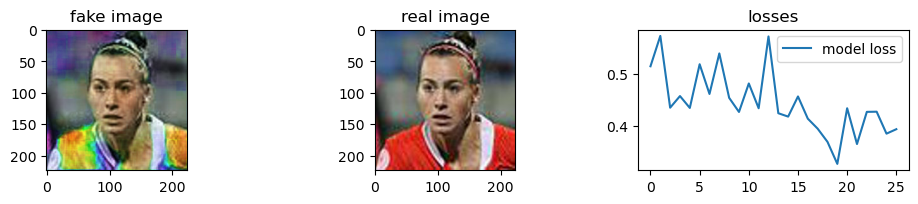

Epoch 26/70: <==========> ------- model loss = 0.3836692273616791, time = 138.0s
Epoch 27/70: <==========> ------- model loss = 0.2709146738052368, time = 138.0s
Epoch 28/70: <==========> ------- model loss = 0.3920445442199707, time = 138.0s
Epoch 29/70: <==========> ------- model loss = 0.3846449851989746, time = 137.0s
Epoch 30/70: <==========> ------- model loss = 0.40391969680786133, time = 137.0s

Validation loss = 0.07811236381530762


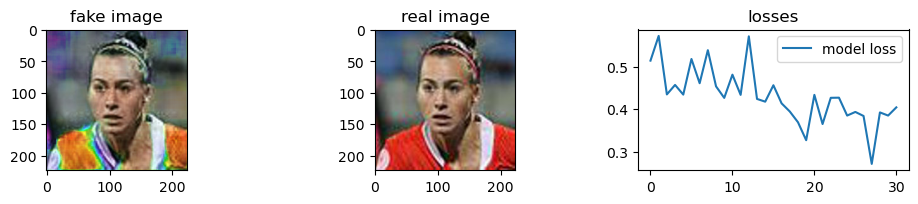

Epoch 31/70: <==========> ------- model loss = 0.41023969650268555, time = 137.0s
Epoch 32/70: <==========> ------- model loss = 0.47126325964927673, time = 137.0s
Epoch 33/70: <==========> ------- model loss = 0.2967595160007477, time = 138.0s
Epoch 34/70: <==========> ------- model loss = 0.3562321960926056, time = 139.0s
Epoch 35/70: <==========> ------- model loss = 0.33993786573410034, time = 140.0s

Validation loss = 0.08033812791109085


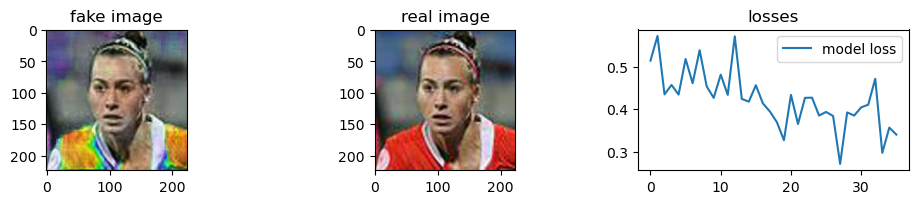

Epoch 36/70: <==========> ------- model loss = 0.4029800295829773, time = 142.0s
Epoch 37/70: <==========> ------- model loss = 0.40697455406188965, time = 141.0s
Epoch 38/70: <==========> ------- model loss = 0.4289597272872925, time = 136.0s
Epoch 39/70: <==========> ------- model loss = 0.428487092256546, time = 137.0s
Epoch 40/70: <==========> ------- model loss = 0.40462395548820496, time = 138.0s

Validation loss = 0.0814872458577156


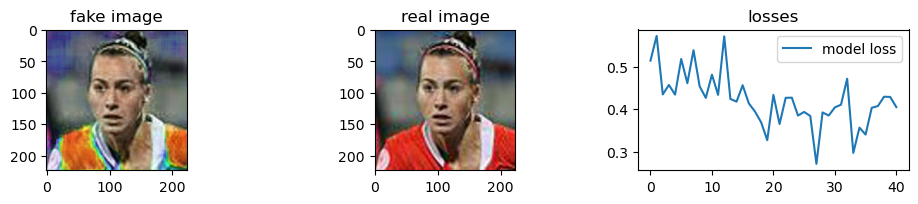

Epoch 41/70: <==========> ------- model loss = 0.5092924237251282, time = 139.0s
Epoch 42/70: <==========> ------- model loss = 0.3247693181037903, time = 138.0s
Epoch 43/70: <==========> ------- model loss = 0.3814248740673065, time = 140.0s
Epoch 44/70: <==========> ------- model loss = 0.3210912048816681, time = 139.0s
Epoch 45/70: <==========> ------- model loss = 0.3134574890136719, time = 153.0s

Validation loss = 0.07865799218416214


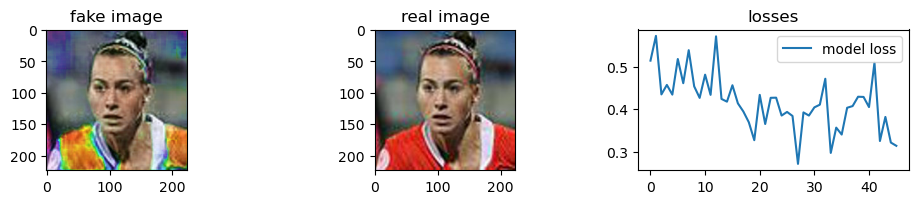

Epoch 46/70: <==========> ------- model loss = 0.4029020369052887, time = 143.0s
Epoch 47/70: <==========> ------- model loss = 0.3323248326778412, time = 140.0s
Epoch 48/70: <==========> ------- model loss = 0.39370638132095337, time = 140.0s
Epoch 49/70: <==========> ------- model loss = 0.33784520626068115, time = 140.0s
Epoch 50/70: <==========> ------- model loss = 0.37540510296821594, time = 139.0s

Validation loss = 0.08094369620084763


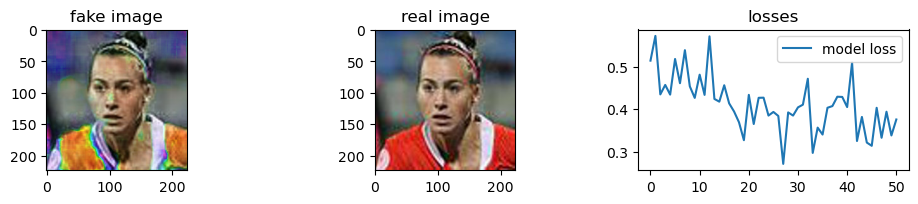

Epoch 51/70: <==========> ------- model loss = 0.38537025451660156, time = 139.0s
Epoch 52/70: <==========> ------- model loss = 0.3374842703342438, time = 141.0s
Epoch 53/70: <==========> ------- model loss = 0.41540074348449707, time = 143.0s
Epoch 54/70: <==========> ------- model loss = 0.3718300461769104, time = 138.0s
Epoch 55/70: <==========> ------- model loss = 0.3879896104335785, time = 138.0s

Validation loss = 0.08210094273090363


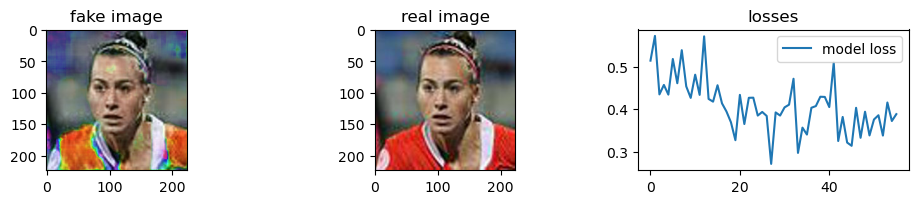

Epoch 56/70: <==========> ------- model loss = 0.3356804847717285, time = 139.0s
Epoch 57/70: <==========> ------- model loss = 0.30680611729621887, time = 140.0s
Epoch 58/70: <==========> ------- model loss = 0.42458048462867737, time = 139.0s
Epoch 59/70: <==========> ------- model loss = 0.3602221608161926, time = 141.0s
Epoch 60/70: <==========> ------- model loss = 0.3131134808063507, time = 140.0s

Validation loss = 0.08294470608234406


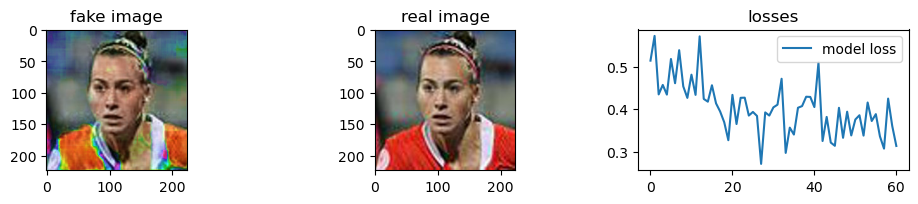

Epoch 61/70: <==========> ------- model loss = 0.3474465012550354, time = 140.0s
Epoch 62/70: <==========> ------- model loss = 0.3275236487388611, time = 139.0s
Epoch 63/70: <==========> ------- model loss = 0.36339062452316284, time = 140.0s
Epoch 64/70: <==========> ------- model loss = 0.3476124405860901, time = 138.0s
Epoch 65/70: <==========> ------- model loss = 0.3792901337146759, time = 142.0s

Validation loss = 0.07961826771497726


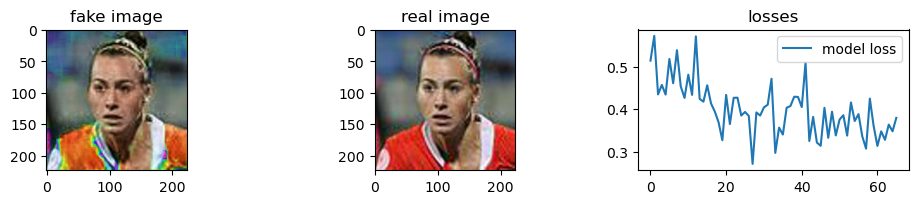

Epoch 66/70: <==========> ------- model loss = 0.3393039405345917, time = 140.0s
Epoch 67/70: <==========> ------- model loss = 0.3540424108505249, time = 137.0s
Epoch 68/70: <==========> ------- model loss = 0.4232640564441681, time = 142.0s
Epoch 69/70: <==========> ------- model loss = 0.27936720848083496, time = 139.0s


In [10]:
%matplotlib inline
loss = train_model3(model, train_loader, epochs=70, device=DEVICE)

Epoch 0/121: <==========> ------- model loss = 0.311242938041687, time = 138.0s

Validation loss = 0.07926198840141296


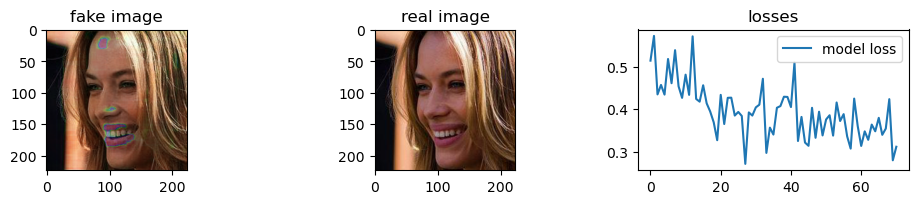

Epoch 1/121: <==========> ------- model loss = 0.398538202047348, time = 136.0s
Epoch 2/121: <==========> ------- model loss = 0.3740530014038086, time = 136.0s
Epoch 3/121: <==========> ------- model loss = 0.3397238850593567, time = 136.0s
Epoch 4/121: <==========> ------- model loss = 0.33576104044914246, time = 136.0s
Epoch 5/121: <==========> ------- model loss = 0.3503020703792572, time = 136.0s

Validation loss = 0.08069530129432678


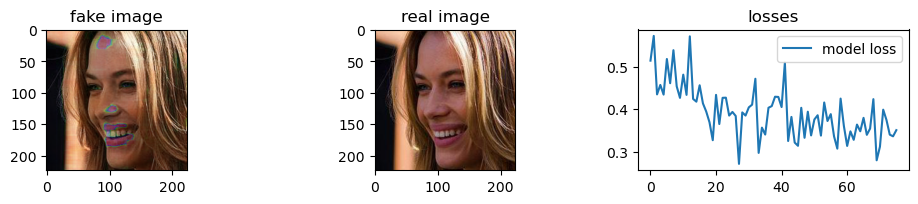

Epoch 6/121: <==========> ------- model loss = 0.3270447552204132, time = 136.0s
Epoch 7/121: <==========> ------- model loss = 0.3786449134349823, time = 136.0s
Epoch 8/121: <==========> ------- model loss = 0.34220629930496216, time = 136.0s
Epoch 9/121: <==========> ------- model loss = 0.32206404209136963, time = 136.0s
Epoch 10/121: <==========> ------- model loss = 0.3659493625164032, time = 136.0s

Validation loss = 0.08335608243942261


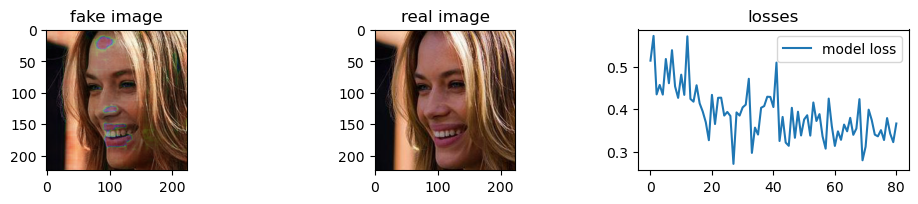

Epoch 11/121: <==========> ------- model loss = 0.3749488294124603, time = 136.0s
Epoch 12/121: <==========> ------- model loss = 0.38800597190856934, time = 136.0s
Epoch 13/121: <==========> ------- model loss = 0.37577518820762634, time = 136.0s
Epoch 14/121: <==========> ------- model loss = 0.34220966696739197, time = 136.0s
Epoch 15/121: <==========> ------- model loss = 0.34819135069847107, time = 136.0s

Validation loss = 0.08453444391489029


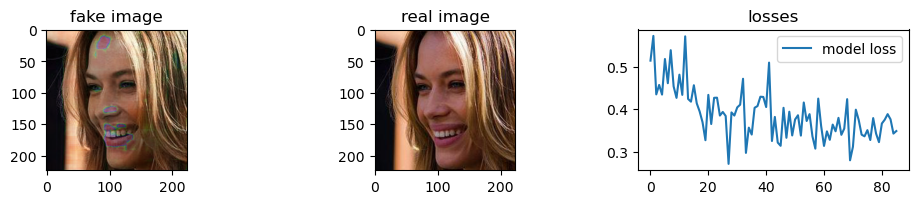

Epoch 16/121: <==========> ------- model loss = 0.3556360602378845, time = 136.0s
Epoch 17/121: <==========> ------- model loss = 0.3075183033943176, time = 136.0s
Epoch 18/121: <==========> ------- model loss = 0.3221260905265808, time = 136.0s
Epoch 19/121: <==========> ------- model loss = 0.3694688379764557, time = 136.0s
Epoch 20/121: <==========> ------- model loss = 0.31580445170402527, time = 136.0s

Validation loss = 0.08040458709001541


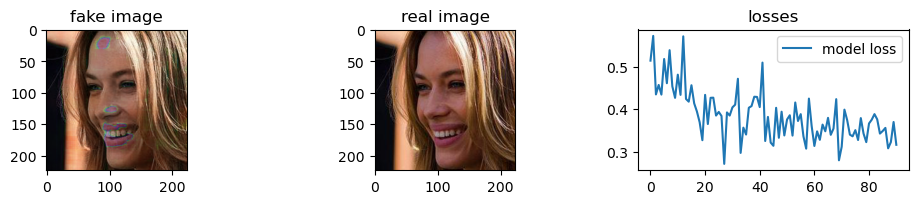

Epoch 21/121: <==========> ------- model loss = 0.44733110070228577, time = 136.0s
Epoch 22/121: <==========> ------- model loss = 0.3711014986038208, time = 136.0s
Epoch 23/121: <==========> ------- model loss = 0.2843722701072693, time = 136.0s
Epoch 24/121: <==========> ------- model loss = 0.29153457283973694, time = 136.0s
Epoch 25/121: <==========> ------- model loss = 0.29452529549598694, time = 136.0s

Validation loss = 0.08129554986953735


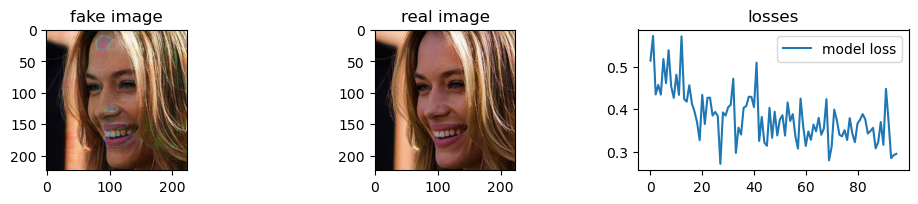

Epoch 26/121: <==========> ------- model loss = 0.3750201165676117, time = 136.0s
Epoch 27/121: <==========> ------- model loss = 0.3781418204307556, time = 136.0s
Epoch 28/121: <==========> ------- model loss = 0.3121435046195984, time = 136.0s
Epoch 29/121: <==========> ------- model loss = 0.45073336362838745, time = 136.0s
Epoch 30/121: <==========> ------- model loss = 0.334145188331604, time = 136.0s

Validation loss = 0.08236375451087952


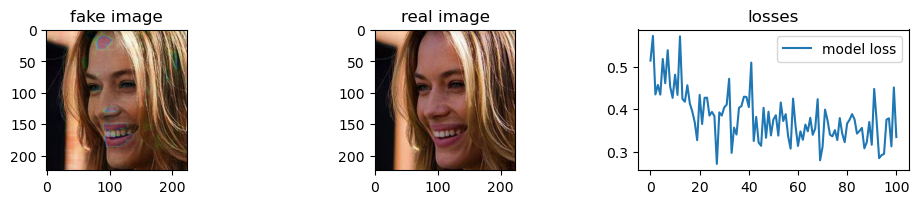

Epoch 31/121: <==========> ------- model loss = 0.2916346490383148, time = 136.0s
Epoch 32/121: <==========> ------- model loss = 0.32697567343711853, time = 136.0s
Epoch 33/121: <==========> ------- model loss = 0.36902156472206116, time = 136.0s
Epoch 34/121: <==========> ------- model loss = 0.39501604437828064, time = 136.0s
Epoch 35/121: <==========> ------- model loss = 0.4698411226272583, time = 136.0s

Validation loss = 0.08245954662561417


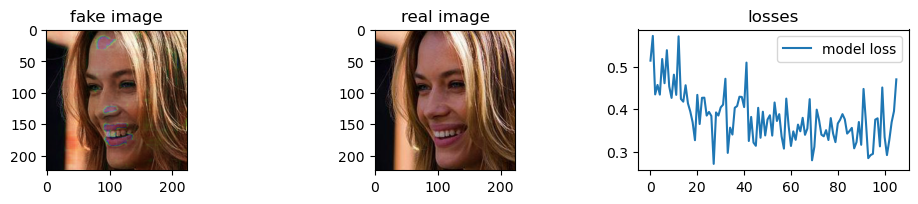

Epoch 36/121: <==========> ------- model loss = 0.3071712851524353, time = 136.0s
Epoch 37/121: <==========> ------- model loss = 0.3769567012786865, time = 136.0s
Epoch 38/121: <==========> ------- model loss = 0.32725536823272705, time = 136.0s
Epoch 39/121: <==========> ------- model loss = 0.34070709347724915, time = 136.0s
Epoch 40/121: <==========> ------- model loss = 0.4033336937427521, time = 136.0s

Validation loss = 0.08367814123630524


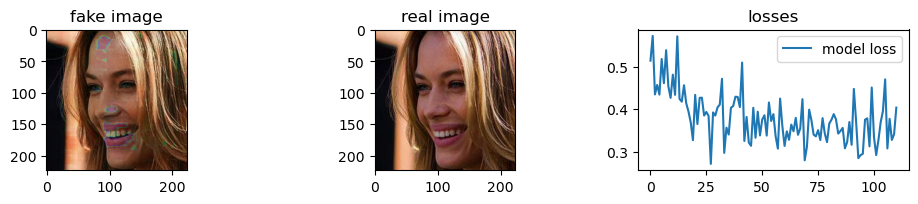

Epoch 41/121: <==========> ------- model loss = 0.39454784989356995, time = 136.0s
Epoch 42/121: <==========> ------- model loss = 0.32739078998565674, time = 136.0s
Epoch 43/121: <==========> ------- model loss = 0.34188124537467957, time = 136.0s
Epoch 44/121: <==========> ------- model loss = 0.39938563108444214, time = 136.0s
Epoch 45/121: <==========> ------- model loss = 0.3480125069618225, time = 136.0s

Validation loss = 0.0814824178814888


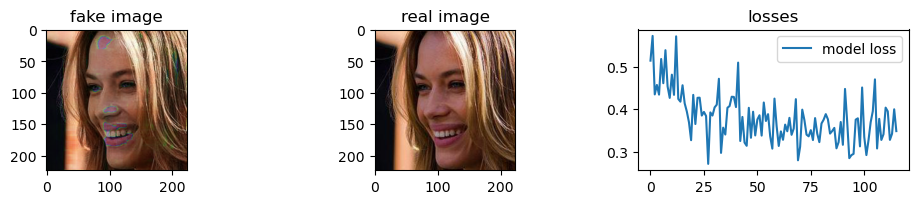

Epoch 46/121: <==========> ------- model loss = 0.2435414046049118, time = 136.0s
Epoch 47/121: <==========> ------- model loss = 0.37408632040023804, time = 136.0s
Epoch 48/121: <==========> ------- model loss = 0.35182181000709534, time = 136.0s
Epoch 49/121: <==========> ------- model loss = 0.36821648478507996, time = 136.0s
Epoch 50/121: <==========> ------- model loss = 0.3631881773471832, time = 136.0s

Validation loss = 0.07997632771730423


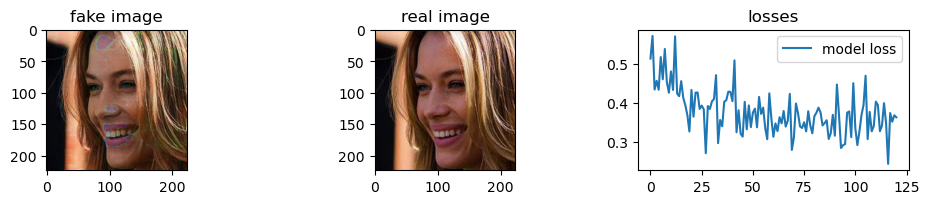

Epoch 51/121: <==========> ------- model loss = 0.4123847782611847, time = 136.0s
Epoch 52/121: <==========> ------- model loss = 0.2973271608352661, time = 136.0s
Epoch 53/121: <==========> ------- model loss = 0.34663715958595276, time = 136.0s
Epoch 54/121: <==========> ------- model loss = 0.39787212014198303, time = 136.0s
Epoch 55/121: <==========> ------- model loss = 0.3294483423233032, time = 136.0s

Validation loss = 0.08097587525844574


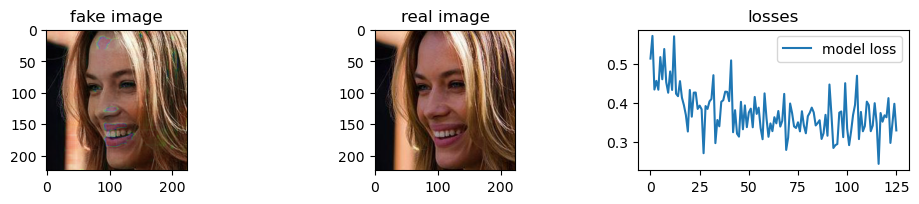

Epoch 56/121: <==========> ------- model loss = 0.3271166682243347, time = 136.0s
Epoch 57/121: <==========> ------- model loss = 0.3434513509273529, time = 136.0s
Epoch 58/121: <==========> ------- model loss = 0.366304486989975, time = 136.0s
Epoch 59/121: <==========> ------- model loss = 0.40297091007232666, time = 136.0s
Epoch 60/121: <==========> ------- model loss = 0.3836936056613922, time = 136.0s

Validation loss = 0.08147773891687393


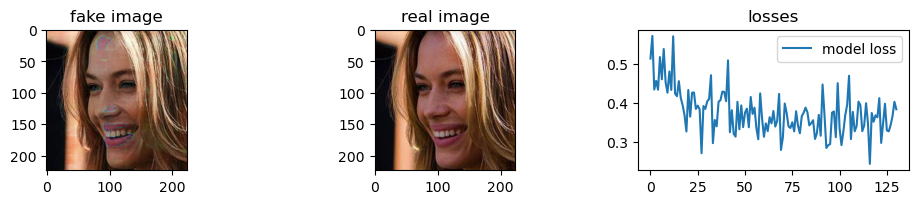

Epoch 61/121: <==========> ------- model loss = 0.3199579417705536, time = 136.0s
Epoch 62/121: <==========> ------- model loss = 0.3683726191520691, time = 136.0s
Epoch 63/121: <==========> ------- model loss = 0.3830849826335907, time = 136.0s
Epoch 64/121: <==========> ------- model loss = 0.43994423747062683, time = 136.0s
Epoch 65/121: <==========> ------- model loss = 0.3711272180080414, time = 136.0s

Validation loss = 0.0834747925400734


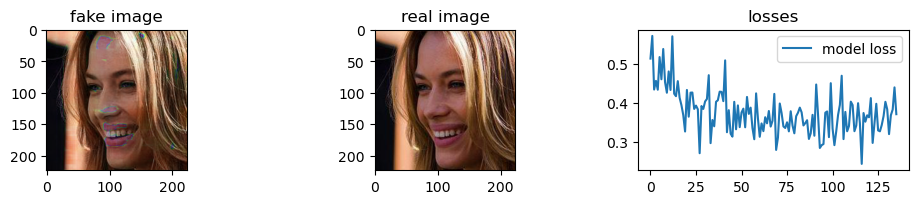

Epoch 66/121: <==========> ------- model loss = 0.2713431715965271, time = 136.0s
Epoch 67/121: <==========> ------- model loss = 0.43440064787864685, time = 136.0s
Epoch 68/121: <==========> ------- model loss = 0.3852291405200958, time = 136.0s
Epoch 69/121: <==========> ------- model loss = 0.33449772000312805, time = 136.0s
Epoch 70/121: <==========> ------- model loss = 0.34741249680519104, time = 136.0s

Validation loss = 0.08398038148880005


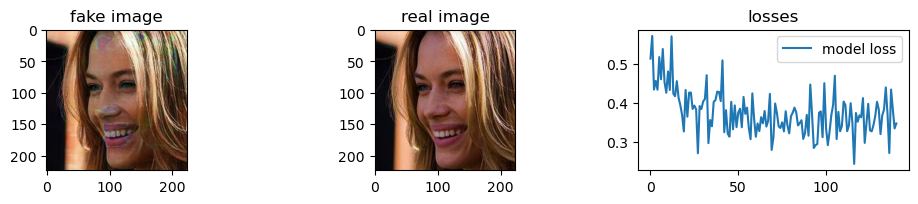

Epoch 71/121: <==========> ------- model loss = 0.330199658870697, time = 136.0s
Epoch 72/121: <==========> ------- model loss = 0.3675779402256012, time = 136.0s
Epoch 73/121: <==========> ------- model loss = 0.35794293880462646, time = 136.0s
Epoch 74/121: <==========> ------- model loss = 0.35018524527549744, time = 136.0s
Epoch 75/121: <==========> ------- model loss = 0.33626607060432434, time = 136.0s

Validation loss = 0.08098778873682022


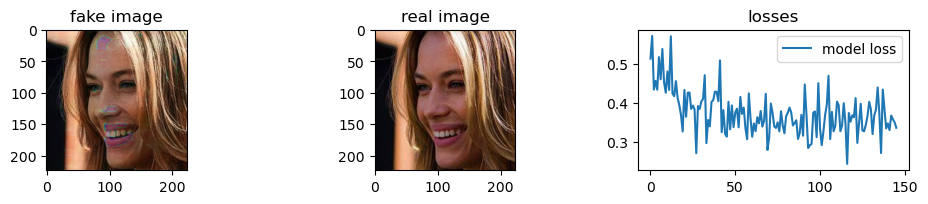

Epoch 76/121: <==========> ------- model loss = 0.3500477373600006, time = 136.0s
Epoch 77/121: <==========> ------- model loss = 0.3286704123020172, time = 136.0s
Epoch 78/121: <==========> ------- model loss = 0.3455955982208252, time = 136.0s
Epoch 79/121: <==========> ------- model loss = 0.42143139243125916, time = 136.0s
Epoch 80/121: <==========> ------- model loss = 0.33444711565971375, time = 136.0s

Validation loss = 0.08322929590940475


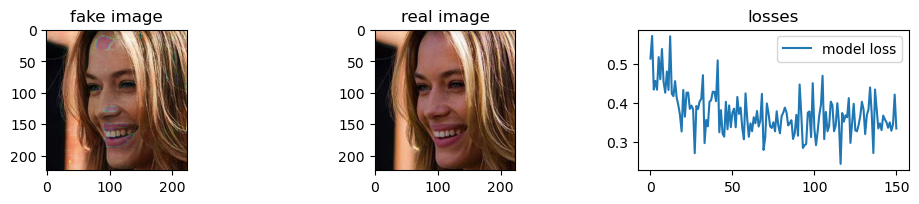

Epoch 81/121: <==========> ------- model loss = 0.4245772957801819, time = 136.0s
Epoch 82/121: <==========> ------- model loss = 0.3209017515182495, time = 136.0s
Epoch 83/121: <==========> ------- model loss = 0.3301238715648651, time = 136.0s
Epoch 84/121: <==========> ------- model loss = 0.39903420209884644, time = 136.0s
Epoch 85/121: <==========> ------- model loss = 0.3013751804828644, time = 136.0s

Validation loss = 0.08129896223545074


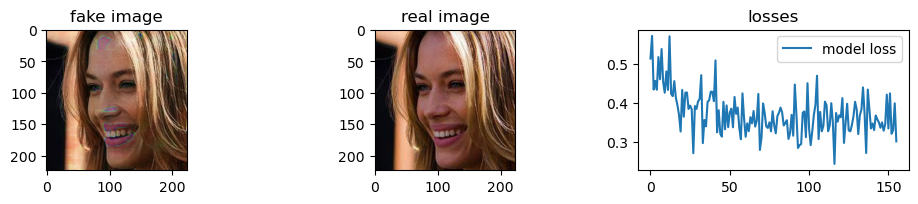

Epoch 86/121: <==========> ------- model loss = 0.37807247042655945, time = 136.0s
Epoch 87/121: <==========> ------- model loss = 0.4208107590675354, time = 136.0s
Epoch 88/121: <==========> ------- model loss = 0.30676087737083435, time = 136.0s
Epoch 89/121: <==========> ------- model loss = 0.28109583258628845, time = 136.0s
Epoch 90/121: <==========> ------- model loss = 0.4147770404815674, time = 136.0s

Validation loss = 0.0836104154586792


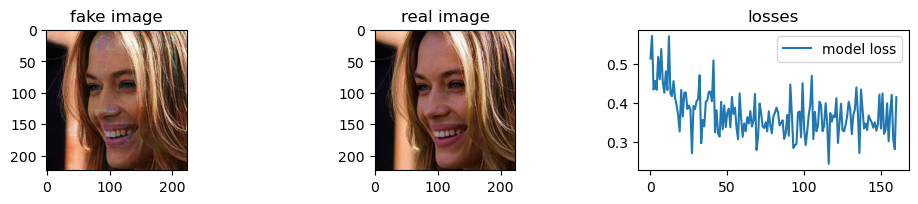

Epoch 91/121: <==========> ------- model loss = 0.306404173374176, time = 136.0s
Epoch 92/121: <==========> ------- model loss = 0.35805657505989075, time = 136.0s
Epoch 93/121: <==========> ------- model loss = 0.3510381281375885, time = 136.0s
Epoch 94/121: <==========> ------- model loss = 0.303704172372818, time = 136.0s
Epoch 95/121: <==========> ------- model loss = 0.30800944566726685, time = 136.0s

Validation loss = 0.08365300297737122


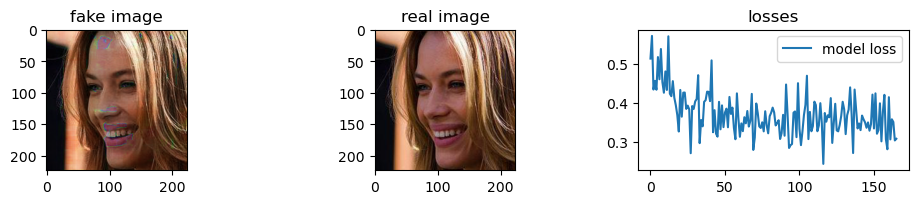

Epoch 96/121: <==========> ------- model loss = 0.3917404115200043, time = 136.0s
Epoch 97/121: <==========> ------- model loss = 0.3105468451976776, time = 136.0s
Epoch 98/121: <==========> ------- model loss = 0.3517360985279083, time = 136.0s
Epoch 99/121: <==========> ------- model loss = 0.40792757272720337, time = 136.0s
Epoch 100/121: <==========> ------- model loss = 0.36733198165893555, time = 136.0s

Validation loss = 0.08283141255378723


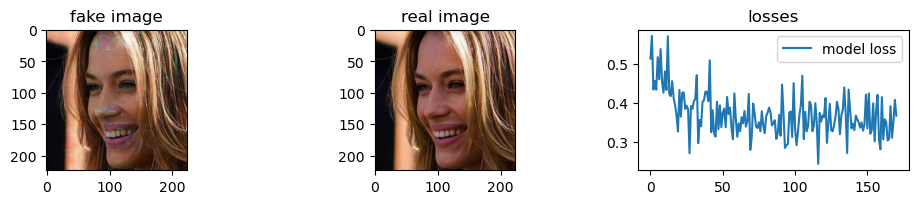

Epoch 101/121: <==========> ------- model loss = 0.30518093705177307, time = 136.0s
Epoch 102/121: <==========> ------- model loss = 0.36676445603370667, time = 136.0s
Epoch 103/121: <==========> ------- model loss = 0.2524186372756958, time = 136.0s
Epoch 104/121: <==========> ------- model loss = 0.28276482224464417, time = 136.0s
Epoch 105/121: <==========> ------- model loss = 0.39771464467048645, time = 136.0s

Validation loss = 0.08352066576480865


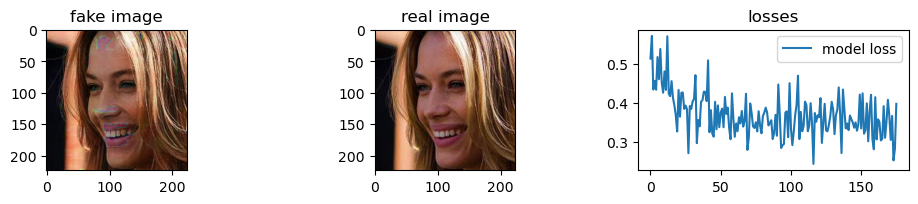

Epoch 106/121: <==========> ------- model loss = 0.3825831413269043, time = 136.0s
Epoch 107/121: <==========> ------- model loss = 0.3338412344455719, time = 136.0s
Epoch 108/121: <==========> ------- model loss = 0.367704302072525, time = 136.0s
Epoch 109/121: <==========> ------- model loss = 0.360094279050827, time = 136.0s
Epoch 110/121: <==========> ------- model loss = 0.42744046449661255, time = 136.0s

Validation loss = 0.0828302651643753


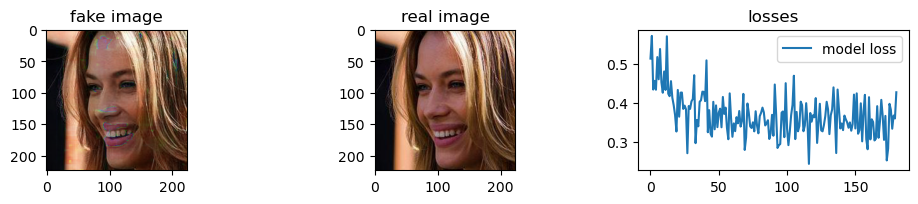

Epoch 111/121: <==========> ------- model loss = 0.36034414172172546, time = 136.0s
Epoch 112/121: <==========> ------- model loss = 0.36058509349823, time = 136.0s
Epoch 113/121: <==========> ------- model loss = 0.3021450638771057, time = 136.0s
Epoch 114/121: <==========> ------- model loss = 0.2736492455005646, time = 136.0s
Epoch 115/121: <==========> ------- model loss = 0.3164428770542145, time = 136.0s

Validation loss = 0.08324791491031647


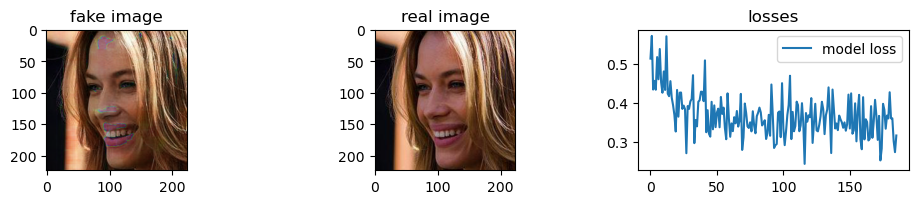

Epoch 116/121: <==========> ------- model loss = 0.39685484766960144, time = 136.0s
Epoch 117/121: <==========> ------- model loss = 0.41057005524635315, time = 136.0s
Epoch 118/121: <==========> ------- model loss = 0.3520970344543457, time = 136.0s
Epoch 119/121: <==========> ------- model loss = 0.3188585937023163, time = 136.0s
Epoch 120/121: <==========> ------- model loss = 0.3736288845539093, time = 136.0s

Validation loss = 0.08346434682607651


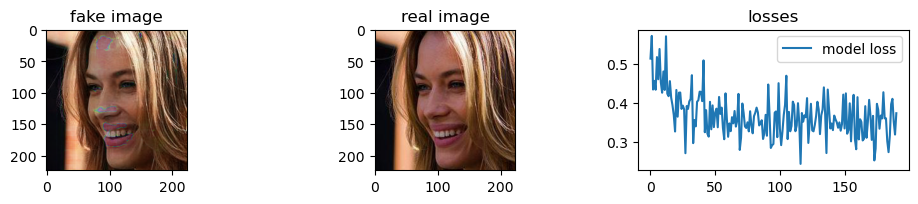

In [38]:
loss = train_model3(model, train_loader, epochs=121, device=DEVICE, loss=loss)

In [9]:
model = StylerNet(optim = torch.optim.Adam)
model_params_amount = (sum(p.numel() for p in model.parameters()))
print(f'Количество параметров модели: {model_params_amount}')
model.load_checkpoint('checkpoints/', 40)

Количество параметров модели: 20191974


Epoch 0/70: <==========> ------- model loss = 0.5258337259292603, time = 148.0s

Validation loss = 0.05439189076423645


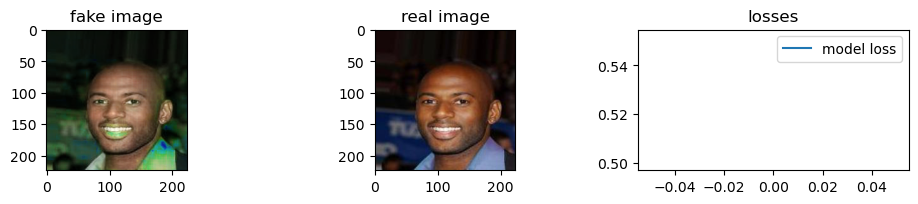

Epoch 1/70: <==========> ------- model loss = 0.5439199805259705, time = 140.0s
Epoch 2/70: <==========> ------- model loss = 0.5710163116455078, time = 138.0s
Epoch 3/70: <==========> ------- model loss = 0.5745511651039124, time = 140.0s
Epoch 4/70: <==========> ------- model loss = 0.538097083568573, time = 138.0s
Epoch 5/70: <==========> ------- model loss = 0.5412079095840454, time = 138.0s

Validation loss = 0.05495847761631012


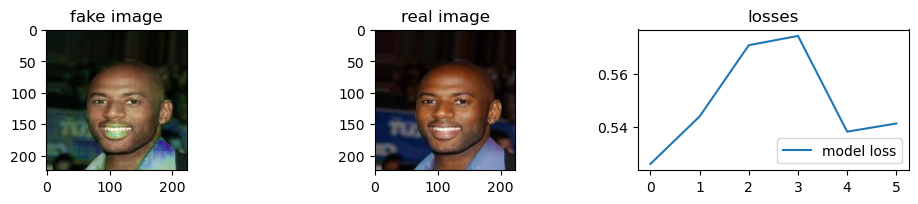

Epoch 6/70: <==========> ------- model loss = 0.5377933382987976, time = 153.0s
Epoch 7/70: <==========> ------- model loss = 0.5351835489273071, time = 140.0s
Epoch 8/70: <==========> ------- model loss = 0.4955410361289978, time = 139.0s
Epoch 9/70: <==========> ------- model loss = 0.5254077911376953, time = 140.0s
Epoch 10/70: <==========> ------- model loss = 0.5180622339248657, time = 140.0s

Validation loss = 0.06367078423500061


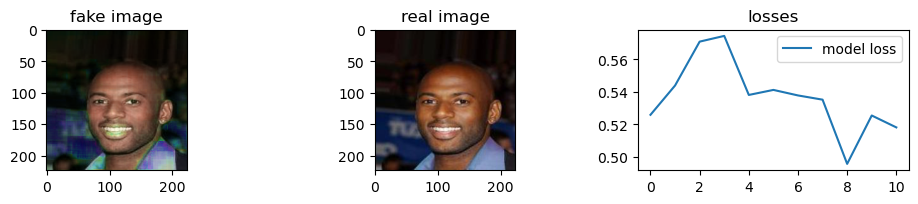

Epoch 11/70: <==========> ------- model loss = 0.4908175468444824, time = 139.0s
Epoch 12/70: <==========> ------- model loss = 0.4936577379703522, time = 141.0s
Epoch 13/70: <==========> ------- model loss = 0.4712577760219574, time = 140.0s
Epoch 14/70: <==========> ------- model loss = 0.47893601655960083, time = 139.0s
Epoch 15/70: <==========> ------- model loss = 0.47494569420814514, time = 140.0s

Validation loss = 0.06653580814599991


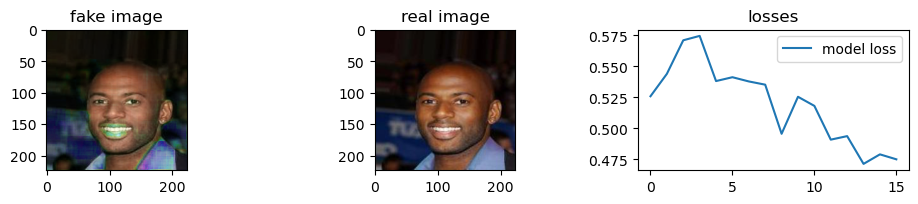

Epoch 16/70: <==========> ------- model loss = 0.4676154851913452, time = 137.0s
Epoch 17/70: <==========> ------- model loss = 0.4893496036529541, time = 139.0s
Epoch 18/70: <==========> ------- model loss = 0.47596994042396545, time = 139.0s
Epoch 19/70: <==========> ------- model loss = 0.47213709354400635, time = 139.0s
Epoch 20/70: <==========> ------- model loss = 0.43691274523735046, time = 139.0s

Validation loss = 0.06848113238811493


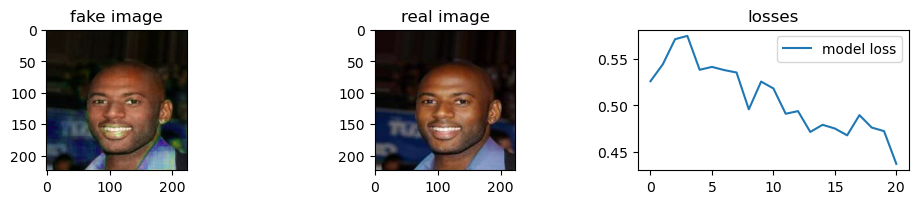

Epoch 21/70: <==========> ------- model loss = 0.4712470471858978, time = 140.0s
Epoch 22/70: <==========> ------- model loss = 0.45373594760894775, time = 149.0s
Epoch 23/70: <==========> ------- model loss = 0.4603339731693268, time = 148.0s
Epoch 24/70: <==========> ------- model loss = 0.4684808850288391, time = 143.0s
Epoch 25/70: <==========> ------- model loss = 0.48176300525665283, time = 144.0s

Validation loss = 0.06788407266139984


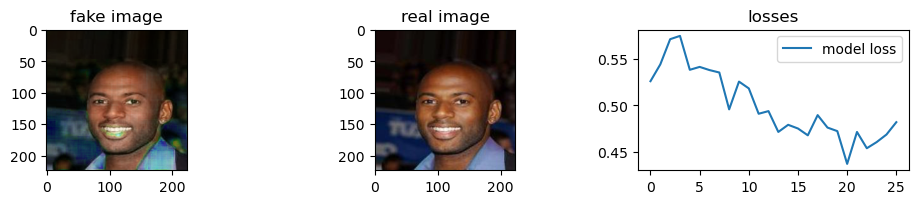

Epoch 26/70: <==========> ------- model loss = 0.4860154688358307, time = 139.0s
Epoch 27/70: <==========> ------- model loss = 0.4454711079597473, time = 140.0s
Epoch 28/70: <==========> ------- model loss = 0.44238513708114624, time = 139.0s
Epoch 29/70: <==========> ------- model loss = 0.4804306924343109, time = 142.0s
Epoch 30/70: <==========> ------- model loss = 0.468025803565979, time = 143.0s

Validation loss = 0.07064107805490494


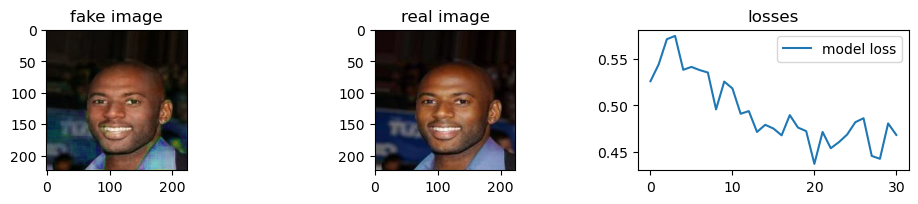

Epoch 31/70: <==========> ------- model loss = 0.463826984167099, time = 148.0s
Epoch 32/70: <==========> ------- model loss = 0.47876298427581787, time = 143.0s
Epoch 33/70: <==========> ------- model loss = 0.4568086266517639, time = 137.0s
Epoch 34/70: <==========> ------- model loss = 0.4438398778438568, time = 138.0s
Epoch 35/70: <==========> ------- model loss = 0.44943922758102417, time = 137.0s

Validation loss = 0.06975362449884415


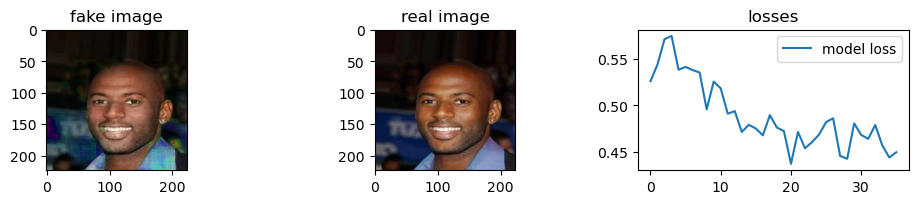

Epoch 36/70: <==========> ------- model loss = 0.4545181691646576, time = 136.0s
Epoch 37/70: <==========> ------- model loss = 0.47368910908699036, time = 136.0s
Epoch 38/70: <==========> ------- model loss = 0.4399440288543701, time = 136.0s
Epoch 39/70: <==========> ------- model loss = 0.469406396150589, time = 136.0s
Epoch 40/70: <==========> ------- model loss = 0.44810619950294495, time = 136.0s

Validation loss = 0.07235992699861526


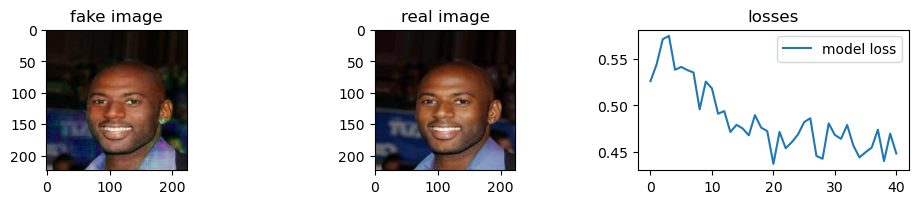

Epoch 41/70: <==========> ------- model loss = 0.45369479060173035, time = 136.0s
Epoch 42/70: <==========> ------- model loss = 0.46232926845550537, time = 136.0s
Epoch 43/70: <==========> ------- model loss = 0.4522800147533417, time = 136.0s
Epoch 44/70: <==========> ------- model loss = 0.4508655071258545, time = 136.0s
Epoch 45/70: <==========> ------- model loss = 0.46199584007263184, time = 136.0s

Validation loss = 0.07144270092248917


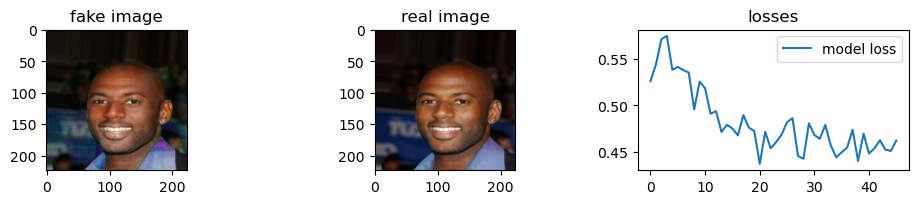

Epoch 46/70: <==========> ------- model loss = 0.45193639397621155, time = 136.0s
Epoch 47/70: <==========> ------- model loss = 0.46152693033218384, time = 136.0s
Epoch 48/70: <==========> ------- model loss = 0.43546923995018005, time = 136.0s
Epoch 49/70: <==========> ------- model loss = 0.44397878646850586, time = 136.0s
Epoch 50/70: <==========> ------- model loss = 0.4327462911605835, time = 136.0s

Validation loss = 0.07177407294511795


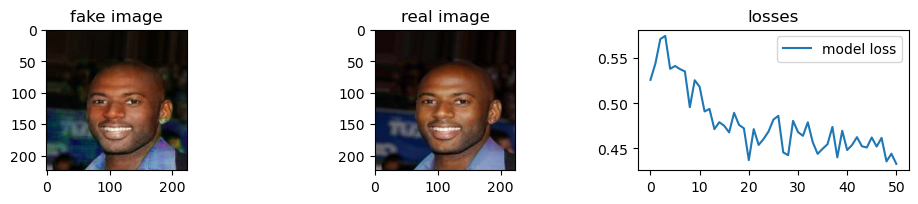

Epoch 51/70: <==========> ------- model loss = 0.435738205909729, time = 136.0s
Epoch 52/70: <==========> ------- model loss = 0.424073189496994, time = 136.0s
Epoch 53/70: <==========> ------- model loss = 0.4429759085178375, time = 136.0s
Epoch 54/70: <==========> ------- model loss = 0.45830824971199036, time = 136.0s
Epoch 55/70: <==========> ------- model loss = 0.467852920293808, time = 136.0s

Validation loss = 0.07476029545068741


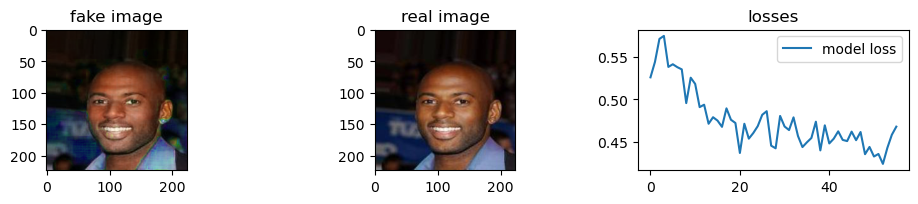

Epoch 56/70: <==========> ------- model loss = 0.41751083731651306, time = 136.0s
Epoch 57/70: <==========> ------- model loss = 0.466295063495636, time = 136.0s
Epoch 58/70: <==========> ------- model loss = 0.41919994354248047, time = 136.0s
Epoch 59/70: <==========> ------- model loss = 0.42290088534355164, time = 136.0s
Epoch 60/70: <==========> ------- model loss = 0.46434664726257324, time = 136.0s

Validation loss = 0.07274387776851654


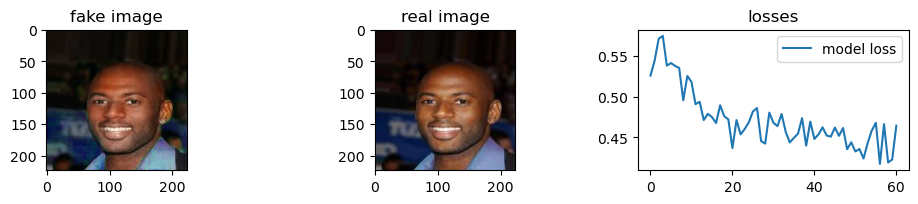

Epoch 61/70: <==========> ------- model loss = 0.4668302834033966, time = 136.0s
Epoch 62/70: <==========> ------- model loss = 0.4003945291042328, time = 136.0s
Epoch 63/70: <==========> ------- model loss = 0.43843674659729004, time = 136.0s
Epoch 64/70: <==========> ------- model loss = 0.45802220702171326, time = 137.0s
Epoch 65/70: <==========> ------- model loss = 0.4255029857158661, time = 136.0s

Validation loss = 0.07269220799207687


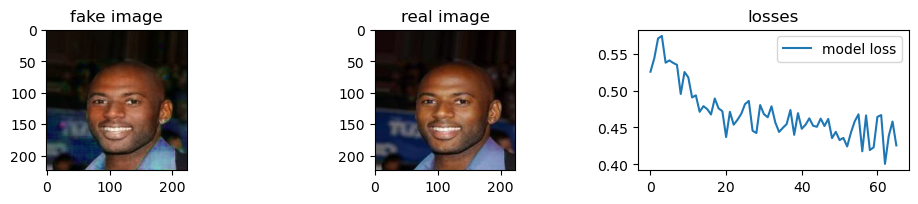

Epoch 66/70: <==========> ------- model loss = 0.4649212658405304, time = 136.0s
Epoch 67/70: <==========> ------- model loss = 0.4339764416217804, time = 136.0s
Epoch 68/70: <==========> ------- model loss = 0.4215703010559082, time = 136.0s
Epoch 69/70: <==========> ------- model loss = 0.4215807616710663, time = 136.0s


In [139]:
%matplotlib inline
loss = train_model3(model, train_loader, epochs=70, device=DEVICE)

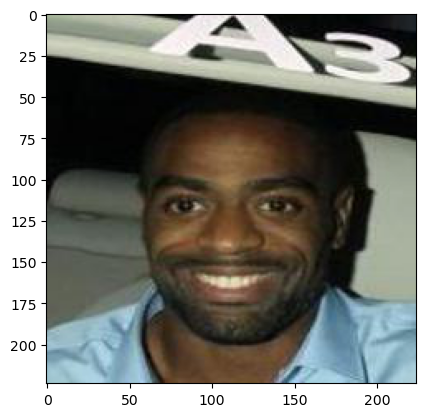

In [126]:
topillow = torchvision.transforms.ToPILImage('HSV')
plt.imshow(topillow(torch.hstack((image[1], image[0]))[0]))

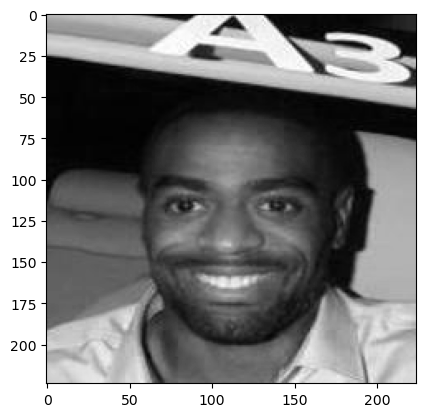

In [132]:
plt.imshow(image[0][0][0], cmap='gray')